# Exploratory data analysis

## 1. Introduction
A json file containing timestamps of user logins in a particular geographic location are provided. The goal is to aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
with open('logins.json','r') as file:
    logins = json.load(file)
    
print(logins.keys())

dict_keys(['login_time'])


In [3]:
print(len(logins['login_time']))
logins['login_time'][:5]

93142


['1970-01-01 20:13:18',
 '1970-01-01 20:16:10',
 '1970-01-01 20:16:37',
 '1970-01-01 20:16:36',
 '1970-01-01 20:26:21']

In [4]:
df = pd.DataFrame(1,index=pd.to_datetime(logins['login_time'], format='%Y-%m-%d %H:%M:%S'),columns=['count'])
logins = df.resample('15T').sum()
logins.head()

,count
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


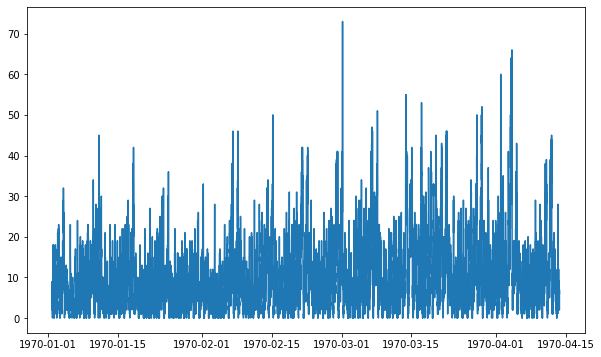

In [5]:
fig = plt.figure(figsize=(10, 6))
plt.plot(logins)

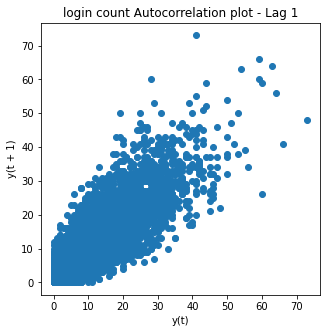

In [6]:
from pandas.plotting import lag_plot

plt.figure(figsize=(5,5))
lag_plot(logins, lag=1)
plt.title('login count Autocorrelation plot - Lag 1');

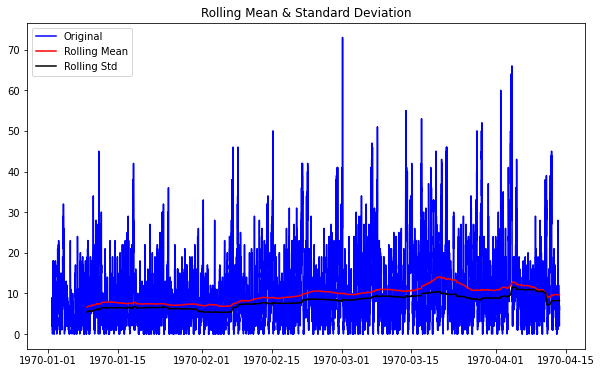

In [7]:
## Weekly 7 days * 24 hours * 4 quarters-per-hour
window = 672 
#Determing rolling statistics
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(logins, color='blue',label='Original')
rolmean = logins.rolling(window).mean()
rolstd = logins.rolling(window).std()
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');

In [8]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(logins, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                -1.033795e+01
p-value                        2.732397e-18
#Lags Used                     3.800000e+01
Number of Observations Used    9.749000e+03
Critical Value (1%)           -3.431021e+00
Critical Value (5%)           -2.861837e+00
Critical Value (10%)          -2.566928e+00
dtype: float64

In [9]:
logins_diff = logins.diff()
logins_diff = logins_diff.dropna(inplace = False)

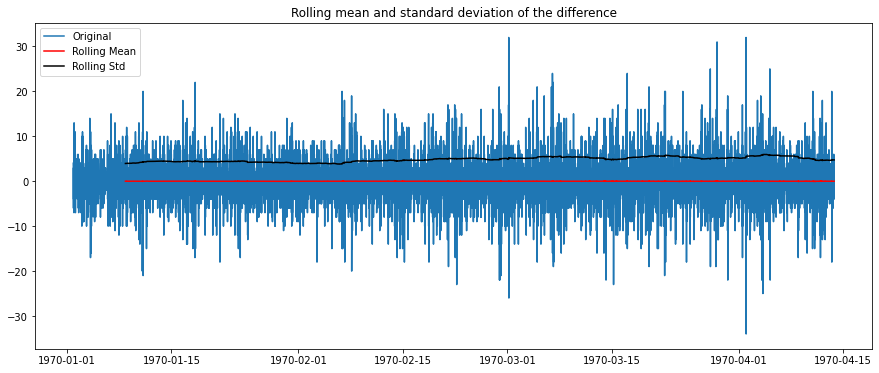

In [10]:
## Weekly 7 days * 24 hours * 4 quarters-per-hour
window = 672
#Determing rolling statistics
fig = plt.figure(figsize=(15, 6))
diff_rolmean = logins_diff.rolling(window).mean()
diff_rolstd = logins_diff.rolling(window).std()

plt.plot(logins_diff, label='Original')
mean = plt.plot(diff_rolmean, color='red', label='Rolling Mean')
std = plt.plot(diff_rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling mean and standard deviation of the difference')
plt.show()

In [11]:
dftest_diff = adfuller(logins_diff, autolag='AIC')

dfoutput_diff = pd.Series(dftest_diff[0:4], index=['Test Statistic',
                                                   'p-value',
                                                   '#Lags Used',
                                                   'Number of Observations Used'])

for key,value in dftest_diff[4].items():
    dfoutput_diff['Critical Value (%s)'%key] = value

dfoutput_diff

Test Statistic                  -28.872915
p-value                           0.000000
#Lags Used                       38.000000
Number of Observations Used    9748.000000
Critical Value (1%)              -3.431021
Critical Value (5%)              -2.861837
Critical Value (10%)             -2.566928
dtype: float64

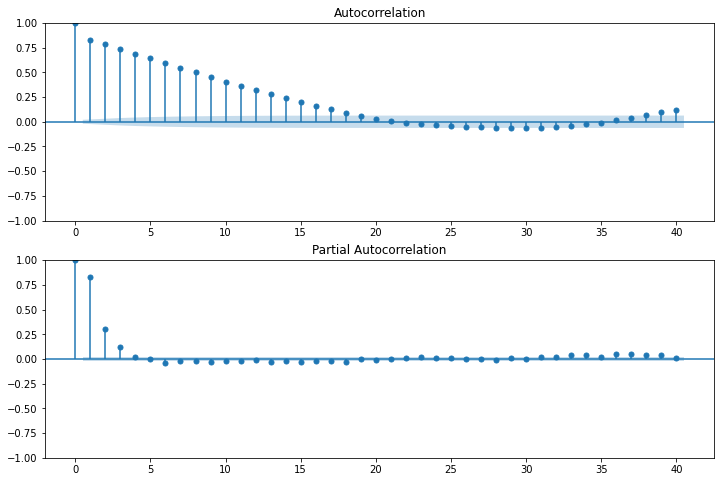

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(logins, ax=ax[0]); # 
plot_pacf(logins, ax=ax[1]);

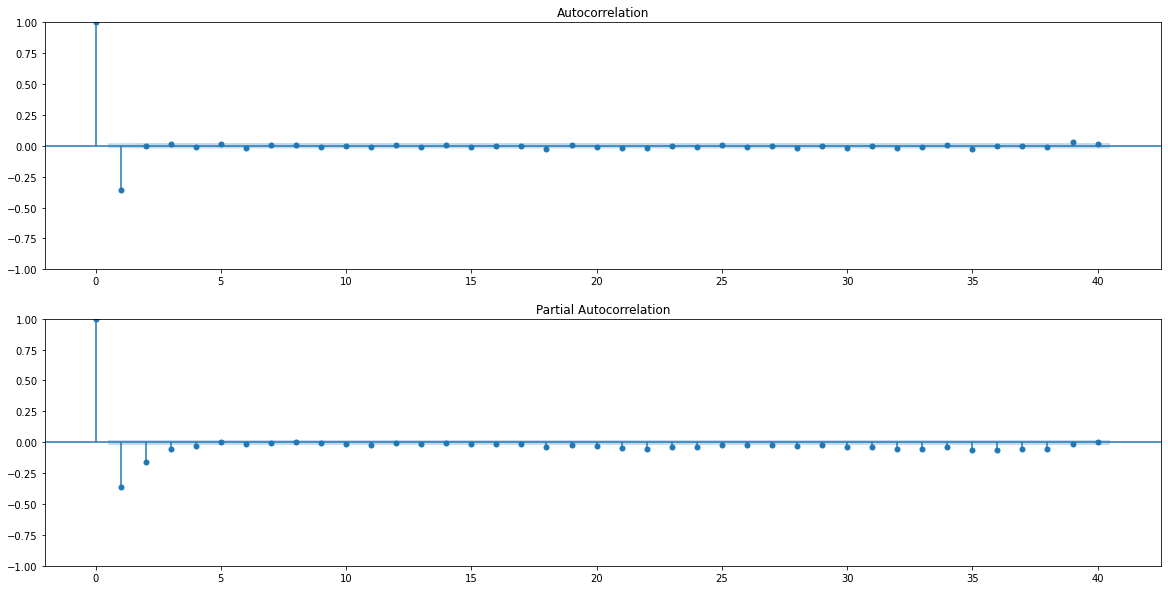

In [13]:
fig, ax = plt.subplots(2, 1, figsize= (20, 10))
plot_acf(logins_diff, ax=ax[0]);
plot_pacf(logins_diff, ax=ax[1]);

# Part 2 ‐ Experiment and metrics design

In [14]:
df['day'] = pd.DatetimeIndex(df.index).day_name()
df['hour'] = pd.DatetimeIndex(df.index).hour
df['weekend'] = df['day'].isin(['Saturday','Sunday'])
df.head()

,count,day,hour,weekend
1970-01-01 20:13:18,1,Thursday,20,False
1970-01-01 20:16:10,1,Thursday,20,False
1970-01-01 20:16:37,1,Thursday,20,False
1970-01-01 20:16:36,1,Thursday,20,False
1970-01-01 20:26:21,1,Thursday,20,False


In [15]:
pd.pivot_table(df, values='count', index=['hour'], columns=['day'], aggfunc=np.sum)

day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
hour,,,,,,,
0,975,531,1254,1123,816,607,687
1,957,414,1562,1355,777,566,686
2,771,312,1608,1608,625,394,482
3,502,236,1574,1647,375,198,299
4,353,206,1719,2107,255,149,245
5,245,121,1093,1102,136,113,135
6,121,66,408,382,67,46,48
7,105,111,178,192,81,64,84
8,109,147,127,153,95,88,99


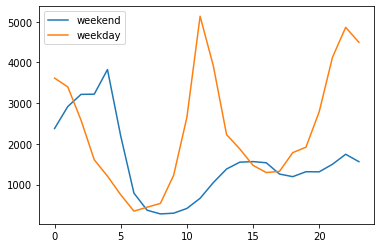

In [16]:
plt.plot(df[df['weekend']].groupby(by='hour').sum().weekend, label='weekend')
plt.plot(df[df['weekend']==False].groupby(by='hour').sum()['count'], label='weekday')

plt.legend(loc='best')
plt.show();